<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/main/notebooks/Learn_proposaI_distribution_lensing_simulator_toy_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet lenstools
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git 
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator.git
!pip install --quiet jax-cosmo numpyro
!pip install --quiet dm-haiku==0.0.5 optax flax
!pip install chainconsumer

In [2]:
import logging
# Removing annoying TFP error message

logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [3]:
%pylab inline
import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import tensorflow_datasets as tfds
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from haiku._src.nets.resnet import ResNet18, ResNet34
from functools import partial
import optax
import haiku as hk
import jax
import jax.numpy as jnp
from numpyro.handlers import condition
from flax.metrics import tensorboard

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [8]:
sample_power_spectrum = jnp.load('/content/sample_power_spectrum_toy_model.npy')

In [9]:
class AffineCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):
   
    net = hk.Linear(128)(x)   
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)    
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net) 
    shifter = tfb.Shift(hk.Linear(output_units)(net))
    scaler = tfb.Scale(jnp.clip(jnp.exp(hk.Linear(output_units)(net)), 1e-2, 1e2))
    
    return tfb.Chain([shifter, scaler])     


class AffineFlow(hk.Module):
    """This is a normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
        
        chain = tfb.Chain([
            tfb.RealNVP(1, bijector_fn=AffineCoupling(name='aff1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(1, bijector_fn=AffineCoupling(name='aff2')),
            tfb.Permute([1,0]),
            tfb.RealNVP(1, bijector_fn=AffineCoupling(name='aff3')),
            tfb.Permute([1,0]),
            tfb.RealNVP(1, bijector_fn=AffineCoupling(name='aff4')),
            tfb.Permute([1,0]),
        ])
        
        nvp = tfd.TransformedDistribution(tfd.Independent(tfd.TruncatedNormal(0.5*jnp.ones(2), 
                                                                              0.1*jnp.ones(2), 
                                                                              0.01,0.99),
                                                          reinterpreted_batch_ndims=1),
                                          bijector=chain)
        return nvp

In [10]:
model_log_proposal = hk.without_apply_rng(hk.transform(lambda x : AffineFlow()().log_prob(x)))

In [11]:
@jax.jit
def loss_fn(params, batch):
    logp = model_log_proposal.apply(params, batch)
    return -jnp.mean(logp)

@jax.jit
def update(params, opt_state, batch):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch)
    updates, new_opt_state = model_log_proposal_optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [27]:
from tqdm import tqdm 

model_log_proposal_params = model_log_proposal.init(jax.random.PRNGKey(10), jnp.zeros([1, 2]))

losses = []

learning_rate=0.001
model_log_proposal_optimizer = optax.adam(learning_rate)
model_log_proposal_opt_state = model_log_proposal_optimizer.init(model_log_proposal_params)

for step in tqdm(range(10000)):
    inds = np.random.randint(0, len(sample_power_spectrum), 128) 
    l, model_log_proposal_params, model_log_proposal_opt_state = update(model_log_proposal_params,
                                                                        model_log_proposal_opt_state, 
                                                                        sample_power_spectrum[inds])
    losses.append(l)


learning_rate=0.0001
model_log_proposal_optimizer = optax.adam(learning_rate)
model_log_proposal_opt_state = model_log_proposal_optimizer.init(model_log_proposal_params)
for step in tqdm(range(50000)):
    inds = np.random.randint(0, len(sample_power_spectrum), 128) 
    l, model_log_proposal_params, model_log_proposal_opt_state = update(model_log_proposal_params, 
                                                                        model_log_proposal_opt_state, 
                                                                        sample_power_spectrum[inds])
    losses.append(l)

/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
100%|██████████| 50000/50000 [06:45<00:00, 123.42it/s]


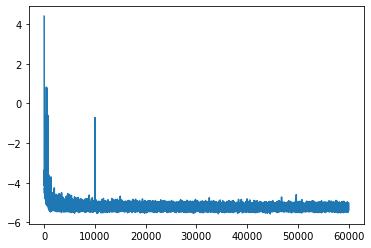

In [28]:
plt.plot(losses)

In [29]:
model_sample = hk.transform(lambda n : AffineFlow()().sample(n, seed=hk.next_rng_key()))

In [30]:
# Cool cool, let's see if we can sample from it now
samps = model_sample.apply(model_log_proposal_params, rng=jax.random.PRNGKey(6543), n=len(sample_power_spectrum))

/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)


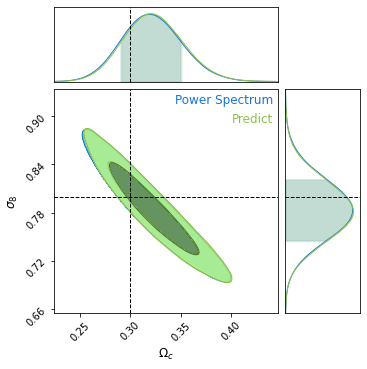

In [31]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(sample_power_spectrum, parameters=["$\Omega_c$", "$\sigma_8$"], name='Power Spectrum')
c.add_chain(samps, parameters=["$\Omega_c$", "$\sigma_8$"], name='Predict')
fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])

In [32]:
sample_full_field = jnp.load('/content/sample_full_field.npy')

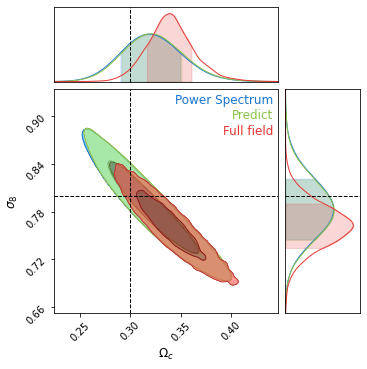

In [33]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(sample_power_spectrum, parameters=["$\Omega_c$", "$\sigma_8$"], name='Power Spectrum')
c.add_chain(samps, parameters=["$\Omega_c$", "$\sigma_8$"], name='Predict')
c.add_chain(sample_full_field, parameters=["$\Omega_c$", "$\sigma_8$"], name='Full field')
fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])

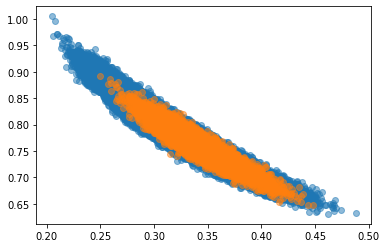

In [34]:
plt.scatter(samps[:,0], samps[:,1], alpha = 0.5)
plt.scatter(sample_full_field[:,0], sample_full_field[:,1],alpha=0.5)

In [35]:
import pickle
from pathlib import Path
path = Path('/content/gdrive/MyDrive/data').expanduser()

with open(path / "params_proposal_lensing_simulator_toy_model.pkl", "wb") as fp:
  pickle.dump(model_log_proposal_params, fp)